# Homework 4
## 28.01.2021
## Akarun Ayça Ersoy

In this homework, we have different datasets from different fields. Each dataset contains unique challenges that are dealt with in different ways.
1. [Wisconsin Diagnostic Breast Cancer](http://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29)  
This is a classification problem that aims to classify a cell as malignant or benign based on some physical features such as: radius, texture, perimeter and smoothness. There are 32 attributes and all of them are numerical. There are 569 instances in the dataset. 200 of them are separated into a test set. This example is relatively "simple" compared to the other ones.   
2. [Communities and Crime](http://archive.ics.uci.edu/ml/datasets/Communities+and+Crime)  
This is a **regression problem** about the crime rates of different areas in the US. There are 1994 instances in this set. Originally there were **128** attributes in this dataset, however 5 of them were non-predictive and ~30 of them contained a great amount of NAs. I chose to remove these attributes since there are many fully available columns without them. 
3. [Cover Type](http://archive.ics.uci.edu/ml/datasets/Covertype)  
This dataset contains information about the properties of 7 different types of trees that cover an area. This is a **multi-class classification problem**. There are 581,012 instances in the set but only 2747 of them are Cottonwood. There is significant **class imbalance** in this dataset. Since the dataset is so large, only 2% of it is used in the calculations. There are **54** attributes in this dataset that are used for prediction.
4. [Mushroom Database](http://archive.ics.uci.edu/ml/datasets/Mushroom)  
The target for this dataset is to classify mushrooms based on whether or not they are poisonous. There are 8124 instances and 3915 of them are poisonous. The dataset contains 22 attributes to make this prediction. They include physical features such as cap-shape, cap-color, odor, veil-type etc. All of the attributes are **categorical**. 

For this homework we will be utilizing 4 different methods to make predictions for theses datasets. These methods are:
1. **Penalized Regression (LASSO)**: lambda will be tuned.
2. **Decision Tree**: minimal number of observations per tree leaf and complexity parameter are tuned.
3. **Random Forest**: number of features to be evaluated is tuned.
4. **Stochastic Gradient Boosting**: depth, learning rate and number of trees are tuned.

We will be performing 5-fold cross validation in order to select the best parameters for these methods. For the classification cases misclassification error and accuracy are used as the comparison metric and for the regression case we will be using RMSE.

In [4]:
#Setting the working directory
setwd('/Users/user/Documents/AYCADoc/BOUN/IE582/HW4')
library(data.table)
library(dplyr)
library(glmnet)
library(randomForest)
library(rpart)
library(gbm)
library(caret)

## 1. Diagnostic Breast Cancer
As stated in the introduction, this dataset is relatively simple. There is no class imbalance and there are no categorical features or missing values. Preprocessing isn't mandatory for this case. The first column is non-predictive (patient ID), therefore it's removed. 

In [8]:
#Dataset 1: Wisconsin Diagnostic Breast Cancer (BC)
#renaming the classes and removing unnecessary columns
dataBC <- fread('wdbc.data')
dataBC$class <- factor(dataBC$V2)
dataBC <- subset(dataBC,select=-c(V1,V2))
table(dataBC$class)


  B   M 
357 212 

In [9]:
#Separation into Train and Test Data
#createDataPartition preserves the ratios of the original dataset
set.seed(1)
inTrain <- createDataPartition(y=dataBC$class, p = 0.64,list=F)
trainBC <- dataBC[inTrain,]
testBC <- dataBC[-inTrain,]
table(trainBC$class)


  B   M 
229 136 

glmnet 

365 samples
 30 predictor
  2 classes: 'B', 'M' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 10 times) 
Summary of sample sizes: 292, 292, 293, 291, 292, 292, ... 
Resampling results across tuning parameters:

  lambda  Accuracy   Kappa    
  0.0020  0.9761592  0.9488630
  0.0034  0.9791656  0.9551913
  0.0048  0.9797061  0.9562811
  0.0062  0.9799763  0.9568417
  0.0076  0.9794360  0.9555650
  0.0090  0.9797062  0.9560972

Tuning parameter 'alpha' was held constant at a value of 1
Accuracy was used to select the optimal model using the largest value.
The final values used for the model were alpha = 1 and lambda = 0.0062.


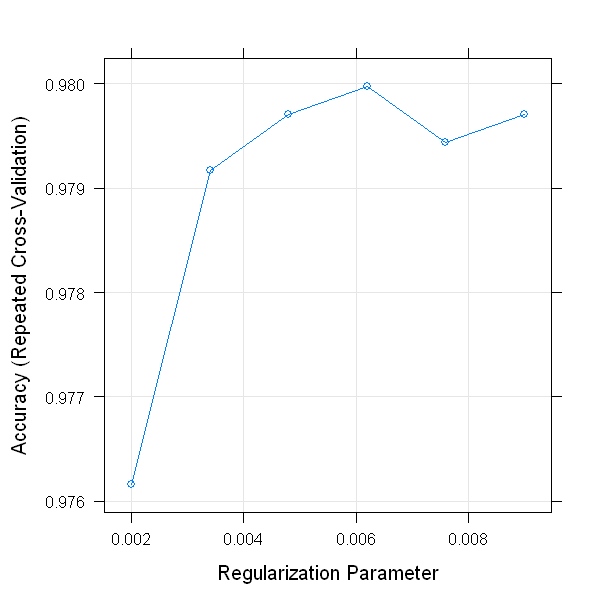

In [13]:
#Penalized Regression (LASSO)
myControl = trainControl(method = "repeatedcv", number = 5, repeats = 10)
myGridPR <- expand.grid(alpha=1,lambda = seq(0.002,0.009,len=6))

lassoBC <- train(class~., data=trainBC, method="glmnet", tuneGrid = myGridPR, trControl=myControl)
print(lassoBC)
options(repr.plot.width=5, repr.plot.height=5)
plot(lassoBC)

In [14]:
#training error
predTrainBC_PR <- predict(lassoBC,trainBC)
trainErrBC_PR <- mean(predTrainBC_PR != trainBC$class)

#test error
predBC_PR <- predict(lassoBC,testBC)
testErrBC_PR <- mean(predBC_PR != testBC$class)
confusionMatrix(table(predBC_PR,testBC$class))

Confusion Matrix and Statistics

         
predBC_PR   B   M
        B 127   8
        M   1  68
                                          
               Accuracy : 0.9559          
                 95% CI : (0.9179, 0.9796)
    No Information Rate : 0.6275          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.9038          
                                          
 Mcnemar's Test P-Value : 0.0455          
                                          
            Sensitivity : 0.9922          
            Specificity : 0.8947          
         Pos Pred Value : 0.9407          
         Neg Pred Value : 0.9855          
             Prevalence : 0.6275          
         Detection Rate : 0.6225          
   Detection Prevalence : 0.6618          
      Balanced Accuracy : 0.9435          
                                          
       'Positive' Class : B               
                                          

In [15]:
#Decision Tree
myGridDT <- expand.grid(cp = c(0,0.001,0.01))
minLeafBC <- c(20,10,5)
for(i in 1:3){
    treeBC <- train(class~.,data=trainBC,method="rpart",tuneGrid = myGridDT,
                trControl=myControl, control = rpart.control(minbucket = minLeafBC[i]))
}
#Highest accuracy obtained was for 5 observations per leaf (as expected)(10 is close)
print(treeBC)

CART 

365 samples
 30 predictor
  2 classes: 'B', 'M' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 10 times) 
Summary of sample sizes: 293, 292, 291, 292, 292, 292, ... 
Resampling results across tuning parameters:

  cp     Accuracy   Kappa   
  0.000  0.9257909  0.840069
  0.001  0.9257909  0.840069
  0.010  0.9274347  0.844166

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.01.


In [16]:
#training error
predTrainBC_DT <- predict(treeBC,trainBC)
trainErrBC_DT <- mean(predTrainBC_DT != trainBC$class)

#test error
predBC_DT <- predict(treeBC,testBC)
testErrBC_DT <- mean(predBC_DT != testBC$class)
confusionMatrix(table(predBC_DT,testBC$class))

Confusion Matrix and Statistics

         
predBC_DT   B   M
        B 120   6
        M   8  70
                                         
               Accuracy : 0.9314         
                 95% CI : (0.8875, 0.962)
    No Information Rate : 0.6275         
    P-Value [Acc > NIR] : <2e-16         
                                         
                  Kappa : 0.854          
                                         
 Mcnemar's Test P-Value : 0.7893         
                                         
            Sensitivity : 0.9375         
            Specificity : 0.9211         
         Pos Pred Value : 0.9524         
         Neg Pred Value : 0.8974         
             Prevalence : 0.6275         
         Detection Rate : 0.5882         
   Detection Prevalence : 0.6176         
      Balanced Accuracy : 0.9293         
                                         
       'Positive' Class : B              
                                         

In [22]:
#Random Forest
set.seed(3)
myGridRF <- expand.grid(mtry=c(5,10,15,20))
forestBC <- train(class~., data=trainBC, method="rf", tuneGrid = myGridRF, 
                  trControl=myControl,ntree = 500, nodesize=5)
print(forestBC)

Random Forest 

365 samples
 30 predictor
  2 classes: 'B', 'M' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 10 times) 
Summary of sample sizes: 292, 292, 292, 292, 292, 291, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
   5    0.9548369  0.9030624
  10    0.9523710  0.8978134
  15    0.9468801  0.8860674
  20    0.9460657  0.8844403

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 5.


In [23]:
#training error
predTrainBC_RF <- predict(forestBC,trainBC)
trainErrBC_RF <- mean(predTrainBC_RF != trainBC$class)

#test error
predBC_RF <- predict(forestBC,testBC)
testErrBC_RF <- mean(predBC_RF != testBC$class)
confusionMatrix(table(predBC_RF,testBC$class))

Confusion Matrix and Statistics

         
predBC_RF   B   M
        B 121   5
        M   7  71
                                          
               Accuracy : 0.9412          
                 95% CI : (0.8995, 0.9692)
    No Information Rate : 0.6275          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.8748          
                                          
 Mcnemar's Test P-Value : 0.7728          
                                          
            Sensitivity : 0.9453          
            Specificity : 0.9342          
         Pos Pred Value : 0.9603          
         Neg Pred Value : 0.9103          
             Prevalence : 0.6275          
         Detection Rate : 0.5931          
   Detection Prevalence : 0.6176          
      Balanced Accuracy : 0.9398          
                                          
       'Positive' Class : B               
                                          

In [19]:
#Stochastic Gradient Boosting
myControl2 <- trainControl(method = "repeatedcv", number = 5, repeats = 2)
myGridGB <- expand.grid(shrinkage = c(0.01,0.05,0.1),interaction.depth=c(1:3),
                         n.trees=c(500,1000,1500),n.minobsinnode=10)
boostBC <- train(class~., data=trainBC, method="gbm", tuneGrid = myGridGB, 
                  trControl=myControl2,verbose=FALSE)
print(boostBC)

Stochastic Gradient Boosting 

365 samples
 30 predictor
  2 classes: 'B', 'M' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 2 times) 
Summary of sample sizes: 292, 293, 291, 292, 292, 292, ... 
Resampling results across tuning parameters:

  shrinkage  interaction.depth  n.trees  Accuracy   Kappa    
  0.01       1                   500     0.9534591  0.8990833
  0.01       1                  1000     0.9698795  0.9348145
  0.01       1                  1500     0.9685096  0.9318980
  0.01       2                   500     0.9561988  0.9049713
  0.01       2                  1000     0.9698795  0.9349525
  0.01       2                  1500     0.9712493  0.9379137
  0.01       3                   500     0.9520887  0.8958551
  0.01       3                  1000     0.9657694  0.9258839
  0.01       3                  1500     0.9698604  0.9348844
  0.05       1                   500     0.9740081  0.9440012
  0.05       1                  1000     0.9740271  0.944

In [20]:
#training error
predTrainBC_GB <- predict(boostBC,trainBC)
trainErrBC_GB <- mean(predTrainBC_GB != trainBC$class)

#test error
predBC_GB <- predict(boostBC,testBC)
testErrBC_GB <- mean(predBC_GB != testBC$class)
confusionMatrix(table(predBC_GB,testBC$class))

Confusion Matrix and Statistics

         
predBC_GB   B   M
        B 126   5
        M   2  71
                                          
               Accuracy : 0.9657          
                 95% CI : (0.9306, 0.9861)
    No Information Rate : 0.6275          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.926           
                                          
 Mcnemar's Test P-Value : 0.4497          
                                          
            Sensitivity : 0.9844          
            Specificity : 0.9342          
         Pos Pred Value : 0.9618          
         Neg Pred Value : 0.9726          
             Prevalence : 0.6275          
         Detection Rate : 0.6176          
   Detection Prevalence : 0.6422          
      Balanced Accuracy : 0.9593          
                                          
       'Positive' Class : B               
                                          

In [24]:
errorBC <- matrix(c(trainErrBC_PR,trainErrBC_DT,trainErrBC_RF,trainErrBC_GB,
                   testErrBC_PR,testErrBC_DT,testErrBC_RF,testErrBC_GB),ncol=4,byrow=TRUE)
colnames(errorBC) <- c("LASSO","D. Tree","R. Forest","S.G.Boosting")
rownames(errorBC) <- c("train error","test error")
errorBC <- as.table(errorBC)
errorBC

                  LASSO     D. Tree   R. Forest S.G.Boosting
train error 0.008219178 0.027397260 0.000000000  0.000000000
test error  0.044117647 0.068627451 0.058823529  0.034313725

### Discussion on Diagnostic Cancer Dataset
We have used 4 different methods in order to classify this dataset. The accuracies for the test set in order are 95, 93, 94 and 96.8%. The cross validation accuracy for decision tree method is lower than the test accuracy. This might imply underfitting but it's a very small difference. For the other cases the cross-validation error and the train error are lower than test error. This might imply overfitting but it's also to be expected.

It's very obvious that random forest and gradient boosting methods have overfit to the training set. The test error is significantly higher in the test set for these methods. The lowest test error is obtained by stochastic gradient boosting.

For penalized regression lambda is chosen as 0.0062. The exact number is not very important since LASSO includes some randomness and the exact numbers are arbitrary. For decision trees, the minimum number of instances at the end nodes is selected as 5. This was expected since when this number is lower the more specific the splits become. However, choosing this number as very low would lead to overfitting. For random forest the number of features to be evaluated is 5. Higher numbers could again lead to overfitting and increasing the run time significantly. For gradient boosting the number of trees is selected as 500, depth is 2 and shrinkage is 0.05.

While we have simply looked at the accuracies and misclassification errors for this dataset, we should remember that this is about cancer diagnosis. It's significantly worse to classify a malignant cell and benign than vice versa. This means that false negatives should be avoided by biasing the model towards malignant. These models already do a better job at classifying malignant cells. For example, gradient boosting has 98% accuracy for classifying malignant cells and 93% for benign cells. However, each mistake is a person and ideally there would be no misclassifications.
For future work, one could choose to intentionally oversample from the 'malignant' class in the preprocessing step or penalize the false negatives in the model building process. 

## 2. Communities and Crime
This dataset contains 128 attributes but about 30 of the attributes contained lots of missing values. There are many approaches to be taken with missing values, such as filling them by creating another regression problem or using the column average. Since there are already a lot of features, I decided to drop them completely. There are also 5 non-predictive columns. After this initial cleanup we end up 95 features. 

In [25]:
#Dataset 2: Crime and Communities
dataCR <- fread('communities.data')
dataCR <- cbind(dataCR[,6:101],dataCR[,128])
dataCR <- subset(dataCR,select=-V31)

#Separation into Train and Test Data
set.seed(1)
inTrain <- createDataPartition(y=dataCR$V128, p = 0.8,list=F)
trainCR <- dataCR[inTrain,]
testCR <- dataCR[-inTrain,]

glmnet 

1597 samples
  95 predictor

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 2 times) 
Summary of sample sizes: 1278, 1278, 1277, 1278, 1277, 1277, ... 
Resampling results across tuning parameters:

  lambda   RMSE       Rsquared   MAE       
  0.00010  0.1378156  0.6471945  0.09782881
  0.00028  0.1374332  0.6487003  0.09687001
  0.00046  0.1373089  0.6491229  0.09639707
  0.00064  0.1373158  0.6489726  0.09607342
  0.00082  0.1374686  0.6481330  0.09593416
  0.00100  0.1376417  0.6471959  0.09590877

Tuning parameter 'alpha' was held constant at a value of 1
RMSE was used to select the optimal model using the smallest value.
The final values used for the model were alpha = 1 and lambda = 0.00046.


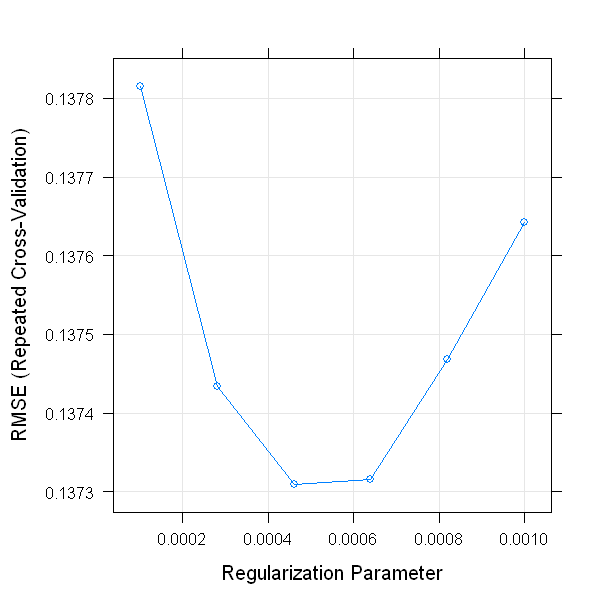

In [26]:
#Penalized Regression (LASSO)
myControl = trainControl(method = "repeatedcv", number = 5, repeats = 2)
myGridPR <- expand.grid(alpha=1,lambda = seq(0.0001,0.001,len=6))

lassoCR <- train(V128~., data=trainCR, method="glmnet", tuneGrid = myGridPR, 
                 trControl=myControl, family="gaussian")
print(lassoCR)
plot(lassoCR)
#training error
predTrainCR_PR <- predict(lassoCR,trainCR)
trainErrCR_PR <- sqrt(mean((trainCR$V128 - predTrainCR_PR)^2))

#test error
predCR_PR <- predict(lassoCR,testCR)
testErrCR_PR <- sqrt(mean((testCR$V128 - predCR_PR)^2))

In [28]:
#Decision Tree
myGridDT <- expand.grid(cp = c(0,0.001,0.01))
minLeaf <- c(20,10,5)
for(i in 1:3){
    treeCR <- train(V128~.,data=trainCR,method="rpart",tuneGrid = myGridDT,
                    trControl=myControl, control = rpart.control(minbucket = minLeaf[i]))
}
#5 is the lowest, I previously printed and checked
print(treeCR)
#training error
predTrainCR_DT <- predict(treeCR,trainCR)
trainErrCR_DT <- sqrt(mean((trainCR$V128 - predTrainCR_DT)^2))

#test error
predCR_DT <- predict(treeCR,testCR)
testErrCR_DT <- sqrt(mean((testCR$V128 - predCR_DT)^2))

CART 

1597 samples
  95 predictor

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 2 times) 
Summary of sample sizes: 1277, 1278, 1277, 1279, 1277, 1278, ... 
Resampling results across tuning parameters:

  cp     RMSE       Rsquared   MAE      
  0.000  0.1771077  0.4751530  0.1207351
  0.001  0.1743718  0.4837756  0.1164098
  0.010  0.1581463  0.5383941  0.1080303

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was cp = 0.01.


In [29]:
#Random Forest
set.seed(3)
myGridRF <- expand.grid(mtry=c(3,5,10,15))
forestCR <- train(V128~., data=trainCR, method="rf", tuneGrid = myGridRF, 
                  trControl=myControl,ntree = 500, nodesize=5)
print(forestCR)
#training error
predTrainCR_RF <- predict(forestCR,trainCR)
trainErrCR_RF <- sqrt(mean((trainCR$V128 - predTrainCR_RF)^2))

#test error
predCR_RF <- predict(forestCR,testCR)
testErrCR_RF <- sqrt(mean((testCR$V128 - predCR_RF)^2))

Random Forest 

1597 samples
  95 predictor

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 2 times) 
Summary of sample sizes: 1277, 1277, 1278, 1278, 1278, 1277, ... 
Resampling results across tuning parameters:

  mtry  RMSE       Rsquared   MAE       
   3    0.1383303  0.6534367  0.09665070
   5    0.1373565  0.6545443  0.09536774
  10    0.1372762  0.6528698  0.09481381
  15    0.1373389  0.6516437  0.09485985

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was mtry = 10.


In [30]:
#Stochastic Gradient Boosting
myGridGB <- expand.grid(shrinkage = c(0.01,0.05,0.1),interaction.depth=c(1:3),
                        n.trees=c(100,500,1000),n.minobsinnode=10)
boostCR <- train(V128~., data=trainCR, method="gbm", tuneGrid = myGridGB, 
                 trControl=myControl,verbose=FALSE)
print(boostCR)
#training error
predTrainCR_GB <- predict(boostCR,trainCR)
trainErrCR_GB <- sqrt(mean((trainCR$V128 - predTrainCR_GB)^2))

#test error
predCR_GB <- predict(boostCR,testCR)
testErrCR_GB <- sqrt(mean((testCR$V128 - predCR_GB)^2))

Stochastic Gradient Boosting 

1597 samples
  95 predictor

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 2 times) 
Summary of sample sizes: 1277, 1278, 1278, 1278, 1277, 1278, ... 
Resampling results across tuning parameters:

  shrinkage  interaction.depth  n.trees  RMSE       Rsquared   MAE       
  0.01       1                   100     0.1752435  0.5711974  0.13030778
  0.01       1                   500     0.1393169  0.6426243  0.09714143
  0.01       1                  1000     0.1369814  0.6518797  0.09415943
  0.01       2                   100     0.1665650  0.6048090  0.12306307
  0.01       2                   500     0.1366525  0.6536419  0.09420486
  0.01       2                  1000     0.1360504  0.6568595  0.09279689
  0.01       3                   100     0.1626273  0.6207145  0.11986064
  0.01       3                   500     0.1363315  0.6551275  0.09342253
  0.01       3                  1000     0.1356840  0.6589596  0.09199218
  0.05       1

In [31]:
errorCR <- matrix(c(trainErrCR_PR,trainErrCR_DT,trainErrCR_RF,trainErrCR_GB,
                   testErrCR_PR,testErrCR_DT,testErrCR_RF,testErrCR_GB),ncol=4,byrow=TRUE)
colnames(errorCR) <- c("LASSO","D. Tree","R. Forest","S.G.Boosting")
rownames(errorCR) <- c("train error","test error")
errorCR <- as.table(errorCR)
errorCR

                 LASSO    D. Tree  R. Forest S.G.Boosting
train error 0.12980668 0.14523765 0.05652436   0.10846690
test error  0.13690076 0.15991387 0.13313486   0.13564847

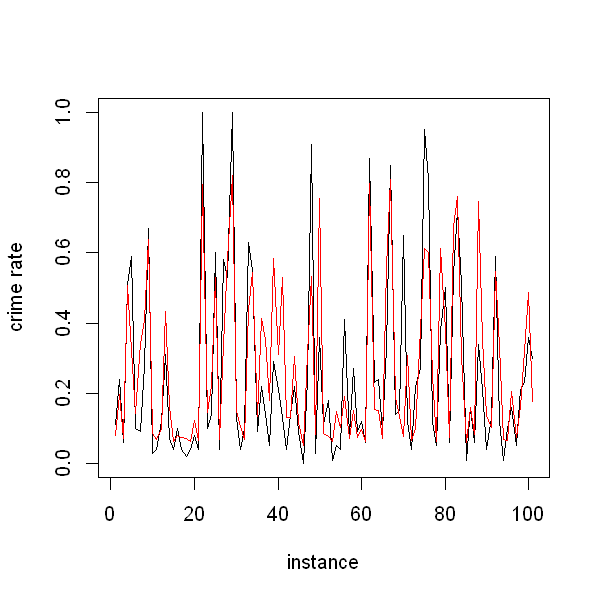

In [32]:
#Example Plot from Gradient Boosting Model
plot(testCR$V128[50:150],type='l',xlab="instance",ylab="crime rate")
lines(predCR_GB[50:150], col="red")

## Discussion on the Crime Rate Dataset
This problem is different from the other ones because it's a regression problem. RMSE is selected as the comparison metric instead of misclassification error. Again, we have implemented the same 4 methods. The train and test errors are tabulated. There isn't significant difference between the train and test errors (maybe except for RandomForest). This indicates that the models are not over- or underfit. The lowest RMSE is obtained with stochastic gradient boosting. 

We also have an example plot for a 100 instance comparison of the predictions obtained by SGB and the actual test data. I have included this in order to get a sense of how good the predictions are. In this section, it appears that the model predicts sharper peaks for some lower rates. The predictions are all reasonable with none under 0 or over 1. 

The penalized regression uses 0.0062 lambda. Decision tree performed the best for 5 instances in the end nodes, and complexity parameter 0.01. These were the same for the previous dataset. Features to be tried for random forest were 10 and SGB performed best for 1000 trees, depth 3 and shrinkage 0.01.

## 3. Cover Type
This is a multi-class classification problem with a class imbalance. This dataset contains a very large number of instances, initially we only select 10% of this dataset. I used the 'downSample' function to create a training set with equal number of instances from each class. Undersampling is a commonly used method to deal with class imbalances. The test set has the same ratio of classes as the original dataset.  
While this approach is intuitive, there is a problem with it. Since I am creating the test and train sets in two unrelated steps, they likely feature some of the same instances, especially for the less common class. For a more accurate error metric, we should make sure that the same instance doesn't repeat itself in the test and train sets. 

In [9]:
#Dataset 3: Cover Type
dataCT <- fread('covtype.data')
table(dataCT$V55)
#this is a very large dataset, we will only be using 0.1
willUse <- createDataPartition(y=dataCT$V55, p = 0.1,list=F)
dataCT <- dataCT[willUse,]
dataCT$cover <- factor(dataCT$V55)
dataCT <- subset(dataCT,select=-V55)

#Separation into Train and Test Data
set.seed(1)
trainCT <- downSample(x=dataCT,y=dataCT$cover)
trainCT <- subset(trainCT,select=-Class)
inTest <- createDataPartition(y=dataCT$cover, p = 0.01,list=F)
testCT <- dataCT[inTest,]


     1      2      3      4      5      6      7 
211840 283301  35754   2747   9493  17367  20510 

glmnet 

1883 samples
  54 predictor
   7 classes: '1', '2', '3', '4', '5', '6', '7' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 10 times) 
Summary of sample sizes: 1506, 1506, 1507, 1508, 1505, 1509, ... 
Resampling results across tuning parameters:

  lambda  Accuracy   Kappa    
  0.0010  0.6915032  0.6400843
  0.0018  0.6920377  0.6407072
  0.0026  0.6881595  0.6361822
  0.0034  0.6881570  0.6361799
  0.0042  0.6847050  0.6321512
  0.0050  0.6824759  0.6295512

Tuning parameter 'alpha' was held constant at a value of 1
Accuracy was used to select the optimal model using the largest value.
The final values used for the model were alpha = 1 and lambda = 0.0018.


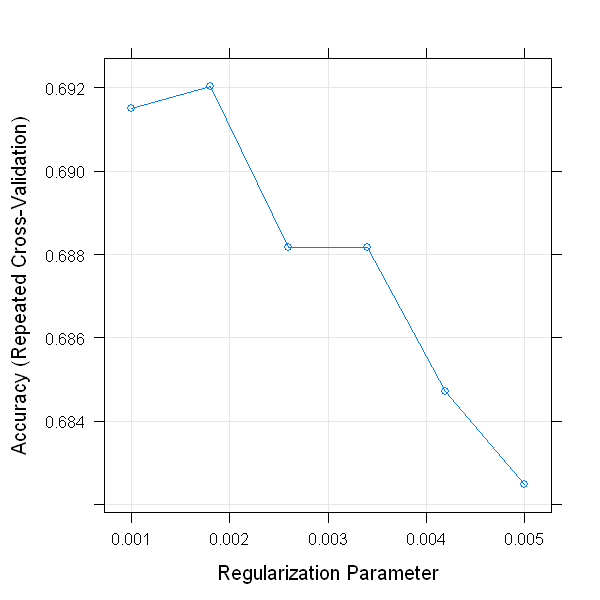

In [36]:
#Penalized Regression (LASSO)
set.seed(21)
myControl = trainControl(method = "repeatedcv", number = 5, repeats = 10)
myGridPR <- expand.grid(alpha=1,lambda = seq(0.001,0.005,len=6))

lassoCT <- train(cover~., data=trainCT, method="glmnet", tuneGrid = myGridPR, trControl=myControl)
print(lassoCT)
plot(lassoCT)

In [39]:
#training error
predTrainCT_PR <- predict(lassoCT,trainCT)
trainErrCT_PR <- mean(predTrainCT_PR != trainCT$cover)

#test error
predCT_PR <- predict(lassoCT,testCT)
testErrCT_PR <- mean(predCT_PR != testCT$cover)
confusionMatrix(table(predCT_PR,testCT$cover))

Confusion Matrix and Statistics

         
predCT_PR   1   2   3   4   5   6   7
        1 139  82   0   0   0   0   4
        2  28 137   1   0   1   0   0
        3   0   2  21   0   0   3   0
        4   0   1   4   3   0   1   0
        5  16  50   0   0   9   1   0
        6   0   7  10   0   0  13   0
        7  29   5   0   0   0   0  17

Overall Statistics
                                          
               Accuracy : 0.5805          
                 95% CI : (0.5393, 0.6209)
    No Information Rate : 0.4863          
    P-Value [Acc > NIR] : 3.131e-06       
                                          
                  Kappa : 0.4102          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4 Class: 5 Class: 6
Sensitivity            0.6557   0.4824  0.58333 1.000000  0.90000  0.72222
Specificity            0.7688   0.9000  0.99088 0.989673  0.88328  0.9699

In [37]:
#Decision Tree
myGridDT <- expand.grid(cp = c(0,0.001,0.01))
minLeaf <- c(20,10,5)
for(i in 1:3){
    treeCT <- train(cover~.,data=trainCT,method="rpart",tuneGrid = myGridDT,
                    trControl=myControl, control = rpart.control(minbucket = minLeaf[i]))
}
#Highest accuracy observed for 5 observation per leaf (as expected)(10 is close)
print(treeCT)

CART 

1883 samples
  54 predictor
   7 classes: '1', '2', '3', '4', '5', '6', '7' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 10 times) 
Summary of sample sizes: 1505, 1505, 1508, 1506, 1508, 1507, ... 
Resampling results across tuning parameters:

  cp     Accuracy   Kappa    
  0.000  0.6517627  0.5937249
  0.001  0.6623816  0.6061160
  0.010  0.6223165  0.5593725

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.001.


In [38]:
#training error
predTrainCT_DT <- predict(treeCT,trainCT)
trainErrCT_DT <- mean(predTrainCT_DT != trainCT$cover)

#test error
predCT_DT <- predict(treeCT,testCT)
testErrCT_DT <- mean(predCT_DT != testCT$cover)
confusionMatrix(table(predCT_DT,testCT$cover))

Confusion Matrix and Statistics

         
predCT_DT   1   2   3   4   5   6   7
        1 125  80   0   0   0   0   2
        2  38 123   2   0   3   0   0
        3   0   2  21   0   0   3   0
        4   0   0   4   3   0   1   0
        5  16  62   0   0   7   2   0
        6   2  16   9   0   0  12   0
        7  31   1   0   0   0   0  19

Overall Statistics
                                          
               Accuracy : 0.5308          
                 95% CI : (0.4894, 0.5719)
    No Information Rate : 0.4863          
    P-Value [Acc > NIR] : 0.01739         
                                          
                  Kappa : 0.3507          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4 Class: 5 Class: 6
Sensitivity            0.5896   0.4331  0.58333 1.000000  0.70000  0.66667
Specificity            0.7796   0.8567  0.99088 0.991394  0.86063  0.9523

In [41]:
#Random Forest
set.seed(3)
myGridRF <- expand.grid(mtry=c(3,5,10,15))
forestCT <- train(cover~., data=trainCT, method="rf", tuneGrid = myGridRF, 
                  trControl=myControl,ntree = 500, nodesize=5)
print(forestCT)

Random Forest 

1883 samples
  54 predictor
   7 classes: '1', '2', '3', '4', '5', '6', '7' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 10 times) 
Summary of sample sizes: 1507, 1505, 1507, 1506, 1507, 1506, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
   3    0.6742248  0.6199332
   5    0.7328098  0.6882811
  10    0.7644715  0.7252178
  15    0.7618201  0.7221240

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 10.


In [42]:
#training error
predTrainCT_RF <- predict(forestCT,trainCT)
trainErrCT_RF <- mean(predTrainCT_RF != trainCT$cover)

#test error
predCT_RF <- predict(forestCT,testCT)
testErrCT_RF <- mean(predCT_RF != testCT$cover)
confusionMatrix(table(predCT_RF,testCT$cover))

Confusion Matrix and Statistics

         
predCT_RF   1   2   3   4   5   6   7
        1 152  73   0   0   0   0   0
        2  23 163   0   0   1   0   0
        3   0   2  27   0   0   3   0
        4   0   0   4   3   0   1   0
        5  13  37   0   0   9   0   1
        6   1   8   5   0   0  14   0
        7  23   1   0   0   0   0  20

Overall Statistics
                                          
               Accuracy : 0.6644          
                 95% CI : (0.6245, 0.7026)
    No Information Rate : 0.4863          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.5171          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4 Class: 5 Class: 6
Sensitivity            0.7170   0.5739  0.75000 1.000000  0.90000  0.77778
Specificity            0.8038   0.9200  0.99088 0.991394  0.91115  0.9752

In [8]:
#Stochastic Gradient Boosting
#I did actually perform cross-validation using the same code as the other datasets
#but it takes very long to run so I am only reporting the best case
boostCT <- gbm(cover~., data=trainCT, n.trees=100,
              interaction.depth=3,shrinkage=0.1,n.minobsinnode=10)
print(boostCT)

Distribution not specified, assuming multinomial ...


Warning message:
"Setting `distribution = "multinomial"` is ill-advised as it is currently broken. It exists only for backwards compatibility. Use at your own risk."Warning message in gbm.fit(x = x, y = y, offset = offset, distribution = distribution, :
"variable 21: V21 has no variation."Warning message in gbm.fit(x = x, y = y, offset = offset, distribution = distribution, :
"variable 29: V29 has no variation."Warning message in gbm.fit(x = x, y = y, offset = offset, distribution = distribution, :
"variable 39: V39 has no variation."Warning message in gbm.fit(x = x, y = y, offset = offset, distribution = distribution, :
"variable 41: V41 has no variation."Warning message in gbm.fit(x = x, y = y, offset = offset, distribution = distribution, :
"variable 50: V50 has no variation."

gbm(formula = cover ~ ., data = trainCT, n.trees = 100, interaction.depth = 3, 
    n.minobsinnode = 10, shrinkage = 0.1)
A gradient boosted model with multinomial loss function.
100 iterations were performed.
There were 54 predictors of which 38 had non-zero influence.


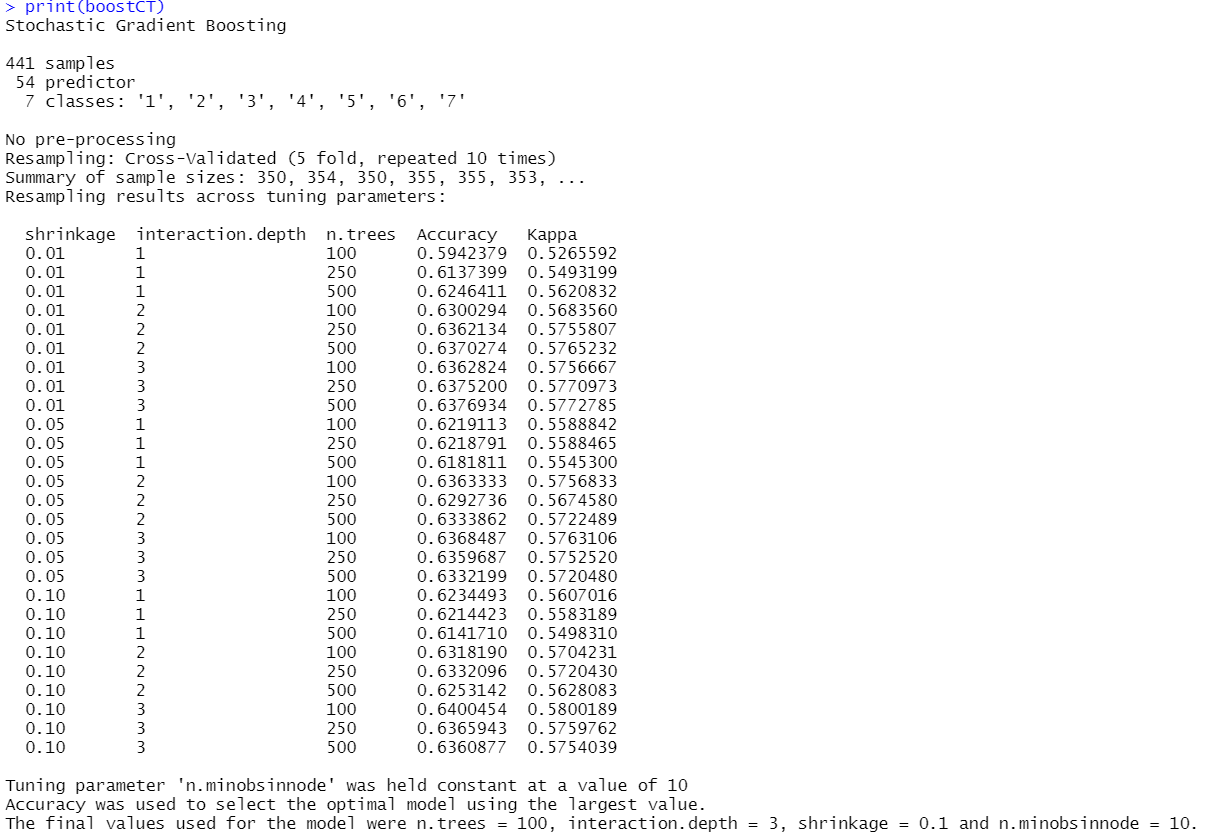

## Discussion on the Cover Type Dataset
This problem was more challenging than the previous sections since it's both a multi-class classification problem and it has a class imbalance problem. We have undersampled from the more prevalent classes, in order to level the playing field. While I have used the 'downSample' function which selects equal number of instances of each class. In my opinion, it might have been better to preserve some amount of imbalance in the set (x1.5-2). Models end up performing the worst for the most common classes, this shows that we might have corrected the set too much. The best performing model is random forest with 66% accuracy, the cross-validation accuracy for it was 76%. This shows signs of overfitting.

I have attached an image of the cross-validation results of SGB method of a previous run. It may be noticed that it works with a smaller training set. After I obtained these results which were not satisfactory, I increased the sample size. However, this and other factors made it run very slow so I couldn't obtain results for the larger set. The error results of SGB and other methods are not comparable because they have different sized training sets (about x5-6 greater). We can draw a different conclusion and say that larger training sets are better for building accurate models. 

## 4. Mushroom Dataset
This dataset contains 22 categorical features to predict whether or not a mushroom is poisonous or edible. One of the features is the same for all instances, therefore it serves no predictive value. In the pre-processing section, this feature is removed. All of the categorical features are dummy encoded, meaning that whether or not they're part of that category is expressed as a binary new feature. This creates 116 predictive features, all binary.

In [10]:
#Dataset 4: Mushroom Types
dataMD <- fread('agaricus-lepiota.data')
poison <- factor(dataMD$p)
colnames(dataMD) <- as.character(c(1:23))
dataMD <- subset(dataMD,select=-c(1,17))

dmy <- dummyVars(" ~ .", data = dataMD)
dummyMD <- data.frame(predict(dmy, newdata = dataMD))
dummyMD <- cbind(dummyMD,poison)

#Separation into Train and Test Data
set.seed(1)
inTrain <- createDataPartition(y=dummyMD$poison, p = 0.8,list=F)
trainMD <- dummyMD[inTrain,]
testMD <- dummyMD[-inTrain,]

glmnet 

6499 samples
 116 predictor
   2 classes: 'e', 'p' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 10 times) 
Summary of sample sizes: 5200, 5199, 5199, 5199, 5199, 5199, ... 
Resampling results across tuning parameters:

  lambda  Accuracy   Kappa    
  0.0010  0.9993846  0.9987674
  0.0018  0.9993846  0.9987674
  0.0026  0.9992770  0.9985518
  0.0034  0.9986000  0.9971957
  0.0042  0.9975690  0.9951305
  0.0050  0.9972305  0.9944524

Tuning parameter 'alpha' was held constant at a value of 1
Accuracy was used to select the optimal model using the largest value.
The final values used for the model were alpha = 1 and lambda = 0.0018.


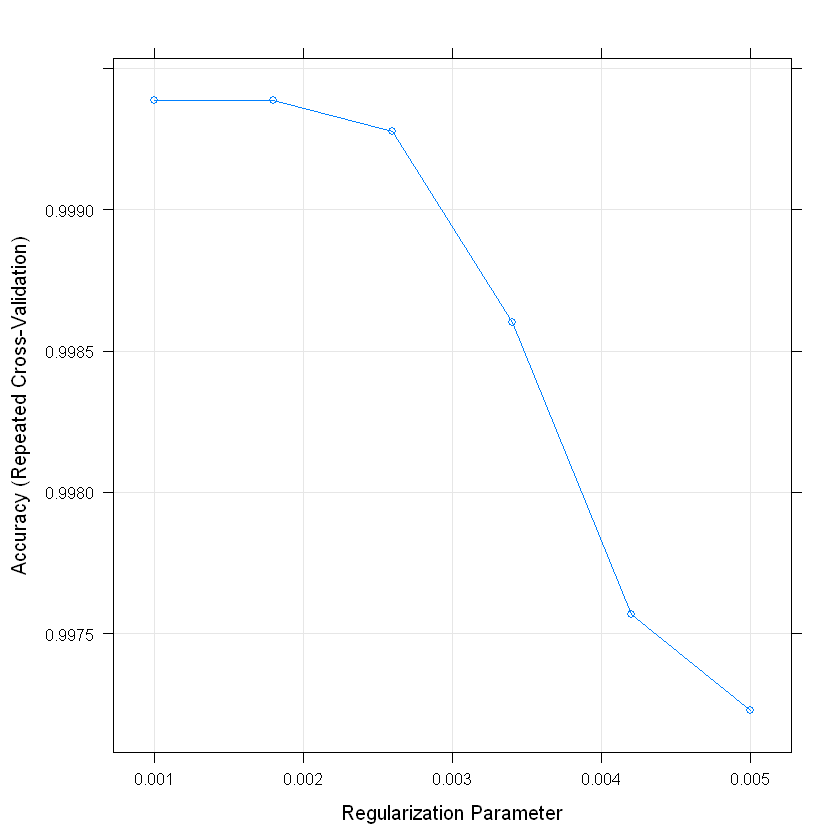

In [11]:
#Penalized Regression (LASSO)
set.seed(21)
myControl = trainControl(method = "repeatedcv", number = 5, repeats = 10)
myGridPR <- expand.grid(alpha=1,lambda = seq(0.001,0.005,len=6))

lassoMD <- train(poison~., data=trainMD, method="glmnet", tuneGrid = myGridPR, trControl=myControl)
print(lassoMD)
plot(lassoMD)

In [12]:
#training error
predTrainMD_PR <- predict(lassoMD,trainMD)
trainErrMD_PR <- mean(predTrainMD_PR != trainMD$poison)

#test error
predMD_PR <- predict(lassoMD,testMD)
testErrMD_PR <- mean(predMD_PR != testMD$poison)
confusionMatrix(table(predMD_PR,testMD$poison))

Confusion Matrix and Statistics

         
predMD_PR   e   p
        e 841   0
        p   0 783
                                     
               Accuracy : 1          
                 95% CI : (0.9977, 1)
    No Information Rate : 0.5179     
    P-Value [Acc > NIR] : < 2.2e-16  
                                     
                  Kappa : 1          
                                     
 Mcnemar's Test P-Value : NA         
                                     
            Sensitivity : 1.0000     
            Specificity : 1.0000     
         Pos Pred Value : 1.0000     
         Neg Pred Value : 1.0000     
             Prevalence : 0.5179     
         Detection Rate : 0.5179     
   Detection Prevalence : 0.5179     
      Balanced Accuracy : 1.0000     
                                     
       'Positive' Class : e          
                                     

In [13]:
#Decision Tree
myGridDT <- expand.grid(cp = c(0.0001,0.001,0.01))
minLeaf <- c(20,10,5)
for(i in 1:3){
    treeMD <- train(poison~.,data=trainMD,method="rpart",tuneGrid = myGridDT,
                    trControl=myControl, control = rpart.control(minbucket = minLeaf[i]))
}
print(treeMD)

CART 

6499 samples
 116 predictor
   2 classes: 'e', 'p' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 10 times) 
Summary of sample sizes: 5198, 5200, 5198, 5200, 5200, 5200, ... 
Resampling results across tuning parameters:

  cp     Accuracy   Kappa    
  1e-04  0.9999384  0.9998766
  1e-03  0.9995229  0.9990444
  1e-02  0.9890135  0.9779834

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 1e-04.


In [14]:
#training error
predTrainMD_DT <- predict(treeMD,trainMD)
trainErrMD_DT <- mean(predTrainMD_DT != trainMD$poison)

#test error
predMD_DT <- predict(treeMD,testMD)
testErrMD_DT <- mean(predMD_DT != testMD$poison)
confusionMatrix(table(predMD_DT,testMD$poison))

Confusion Matrix and Statistics

         
predMD_DT   e   p
        e 841   0
        p   0 783
                                     
               Accuracy : 1          
                 95% CI : (0.9977, 1)
    No Information Rate : 0.5179     
    P-Value [Acc > NIR] : < 2.2e-16  
                                     
                  Kappa : 1          
                                     
 Mcnemar's Test P-Value : NA         
                                     
            Sensitivity : 1.0000     
            Specificity : 1.0000     
         Pos Pred Value : 1.0000     
         Neg Pred Value : 1.0000     
             Prevalence : 0.5179     
         Detection Rate : 0.5179     
   Detection Prevalence : 0.5179     
      Balanced Accuracy : 1.0000     
                                     
       'Positive' Class : e          
                                     

In [15]:
#Decision Tree Method gives very high accuracy
#Random Forest
set.seed(3)
myGridRF <- expand.grid(mtry=c(3,4,5))
forestMD <- train(poison~., data=trainMD, method="rf", tuneGrid = myGridRF, 
                  trControl=myControl,ntree = 50, nodesize=5)
print(forestMD)

Random Forest 

6499 samples
 116 predictor
   2 classes: 'e', 'p' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 10 times) 
Summary of sample sizes: 5199, 5198, 5200, 5199, 5200, 5199, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
  3     0.9954148  0.9908126
  4     0.9998307  0.9996610
  5     1.0000000  1.0000000

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 5.


In [16]:
#training error
predTrainMD_RF <- predict(forestMD,trainMD)
trainErrMD_RF <- mean(predTrainMD_RF != trainMD$poison)

#test error
predMD_RF <- predict(forestMD,testMD)
testErrMD_RF <- mean(predMD_RF != testMD$poison)
confusionMatrix(table(predMD_RF,testMD$poison))

Confusion Matrix and Statistics

         
predMD_RF   e   p
        e 841   0
        p   0 783
                                     
               Accuracy : 1          
                 95% CI : (0.9977, 1)
    No Information Rate : 0.5179     
    P-Value [Acc > NIR] : < 2.2e-16  
                                     
                  Kappa : 1          
                                     
 Mcnemar's Test P-Value : NA         
                                     
            Sensitivity : 1.0000     
            Specificity : 1.0000     
         Pos Pred Value : 1.0000     
         Neg Pred Value : 1.0000     
             Prevalence : 0.5179     
         Detection Rate : 0.5179     
   Detection Prevalence : 0.5179     
      Balanced Accuracy : 1.0000     
                                     
       'Positive' Class : e          
                                     

In [17]:
#Stochastic Gradient Boosting
myGridGB <- expand.grid(shrinkage = c(0.01,0.05,0.1),interaction.depth=c(1:3),
                        n.trees=c(50,100,150),n.minobsinnode=10)
boostMD <- train(poison~., data=trainMD, method="gbm", tuneGrid = myGridGB, 
                 trControl=myControl,verbose=FALSE)
print(boostMD)

Stochastic Gradient Boosting 

6499 samples
 116 predictor
   2 classes: 'e', 'p' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 10 times) 
Summary of sample sizes: 5199, 5200, 5199, 5199, 5199, 5199, ... 
Resampling results across tuning parameters:

  shrinkage  interaction.depth  n.trees  Accuracy   Kappa    
  0.01       1                   50      0.8841371  0.7693874
  0.01       1                  100      0.8841371  0.7693874
  0.01       1                  150      0.8841371  0.7693874
  0.01       2                   50      0.9478084  0.8956308
  0.01       2                  100      0.9725358  0.9450024
  0.01       2                  150      0.9718422  0.9435974
  0.01       3                   50      0.9694264  0.9387335
  0.01       3                  100      0.9840442  0.9680102
  0.01       3                  150      0.9843059  0.9685339
  0.05       1                   50      0.9718422  0.9435974
  0.05       1                  100      0.9833

In [18]:
#training error
predTrainMD_GB <- predict(boostMD,trainMD)
trainErrMD_GB <- mean(predTrainMD_GB != trainMD$poison)

#test error
predMD_GB <- predict(boostMD,testMD)
testErrMD_GB <- mean(predMD_GB != testMD$poison)
confusionMatrix(table(predMD_GB,testMD$poison))

Confusion Matrix and Statistics

         
predMD_GB   e   p
        e 841   0
        p   0 783
                                     
               Accuracy : 1          
                 95% CI : (0.9977, 1)
    No Information Rate : 0.5179     
    P-Value [Acc > NIR] : < 2.2e-16  
                                     
                  Kappa : 1          
                                     
 Mcnemar's Test P-Value : NA         
                                     
            Sensitivity : 1.0000     
            Specificity : 1.0000     
         Pos Pred Value : 1.0000     
         Neg Pred Value : 1.0000     
             Prevalence : 0.5179     
         Detection Rate : 0.5179     
   Detection Prevalence : 0.5179     
      Balanced Accuracy : 1.0000     
                                     
       'Positive' Class : e          
                                     

In [19]:
errorMD <- matrix(c(trainErrMD_PR,trainErrMD_DT,trainErrMD_RF,trainErrMD_GB,
                    testErrMD_PR,testErrMD_DT,testErrMD_RF,testErrMD_GB),ncol=4,byrow=TRUE)
colnames(errorMD) <- c("LASSO","D. Tree","R. Forest","S.G.Boosting")
rownames(errorMD) <- c("train error","test error")
errorMD <- as.table(errorMD)
errorMD

                   LASSO      D. Tree    R. Forest S.G.Boosting
train error 0.0004616095 0.0000000000 0.0000000000 0.0000000000
test error  0.0000000000 0.0000000000 0.0000000000 0.0000000000

## Discussion on the Mushroom Dataset
Even though I have used all the methods on this dataset, it was not very useful to continue after decision tree. Since decision tree already gives 100%, there is no margin for improvement by building a forest out of many decision trees. The run time for the code also significantly increases for random forest and gradient boosting. 

There really isn't much to discuss for this dataset, since all cross-validation errors, training errors and test errors are 0%. 
##### High Accuracy
It's expected for us to obtain very low errors for this dataset, since humans have been classifying mushrooms as poisonous or edible for thousands of centuries just by observing their physical attributes. It should also be noted that each attribute contained only a few strict categories that each instance was classified into. In nature, a certain mushroom could be in the yellow-red spectrum but in this dataset it has to be one or the other. A more challenging version of this problem would be to represent some of these features as numerical quantities that lie on a spectrum. I hypothesize that the errors would be higher in that case.
Similar to the cancer diagnosis dataset, the false negatives are worse for this dataset. It's significantly worse to classify a poisonous mushroom as edible than vice versa. 

# Concluding Remarks
In this project, we have looked at 4 different datasets and 4 different methods. Each dataset had unique problems associated with it. I think a justifiable conclusion is that we need to fully understand the domain and task at hand. While it's possible to obtain low errors by going in blind, having previous knowledge would help us assess the importance of features, understand the roots of the misclassification errors, draw conclusions and suggest better data collection methods. 

Each of these methods gave reasonable results for all of the problems. As expected randomForest and SGB performed better than decision tree, since they're an update on it. However, decision tree method never had an overfitting problem and provided reasonable predictions. Penalized regression and decision tree have significantly lower runtimes, which may be an important point for larger datasets. 
##### Future Work
Performing cross-validation for more combinations of parameters would help us avoid overfitting the model. Some of the results presented here picked the lowest/highest parameter that I provided and ideally the best one should lie somewhere in the middle. 

More pre-processing is definitely necessary for some of the datasets. Normalizing the data may significantly help. Other approaches to the class imbalance problem may also yield better results.